# Logistic Regression Model
Tristan Miller, 9/18/2019



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outline-of-model" data-toc-modified-id="Outline-of-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outline of model</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Creating-features/labels" data-toc-modified-id="Creating-features/labels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Creating features/labels</a></span></li><li><span><a href="#Training/validation/test-split" data-toc-modified-id="Training/validation/test-split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training/validation/test split</a></span></li><li><span><a href="#Train-root-model-on-playground_set" data-toc-modified-id="Train-root-model-on-playground_set-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Train root model on playground_set</a></span></li><li><span><a href="#Train-quality-model-on-playground-set" data-toc-modified-id="Train-quality-model-on-playground-set-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train quality model on playground set</a></span></li><li><span><a href="#Producing-labels-given-youtube-video" data-toc-modified-id="Producing-labels-given-youtube-video-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Producing labels given youtube video</a></span></li><li><span><a href="#Plotting-learning-curves" data-toc-modified-id="Plotting-learning-curves-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Plotting learning curves</a></span></li></ul></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the model</a></span><ul class="toc-item"><li><span><a href="#Setting-up-bash-commands" data-toc-modified-id="Setting-up-bash-commands-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Setting up bash commands</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Optimization</a></span></li></ul></li></ul></div>

## Outline of model

For the minimum viable product, I will use the simplest model: logistic regression.  There will be four classification models:
1. root (13 classes: A, Bb, B, etc. and ~) (~ indicates no chord.  Some labeled data may be nan, meaning unidentifiable)
1. character (6 classes: unison, power, maj, min, dim, aug) (always '' if root is ~)
1. add (9 classes: min9, 9, 4, tt, min6, 6, min7, maj7, '') (always '' if root is ~)
1. inversion (3 classes: /3, /5, '') (always '' if root is ~)

Note that each of these chord properties is encoded as an integer, e.g. rootnum=-1 corresponds to root='~'

mp3 data will undergo the following preparation steps:
1. Converted to dB spectra
1. Normalize by song
1. Pad low and high frequencies for later transposition
1. Add row and column to the beginning, for a flag to indicate beginning of each song.
1. Abridged to be same length as chord file, remove any rows which have nan root.
1. Concatenated song data.
1. (Training data only) Duplicated 12 times, each with a different transposition.
1. Identify root. (ie use training labels, or use predictive model)
1. Each time step is transposed to have root at same location.  During this step, any rows with root = -1 are removed.
1. Identify quality, add, and inversion.

Chord labels will undergo the following preparation steps:
1. Chords are "blockified", meaning a single chord is identified for each block of time (currently this is done by using whatever chord is in the middle of that interval).
1. Chord strings are translated to root, character, add, and inversion.
1. Abridged to be same length as feature data, removing any rows with nan root.
1. (Training data only) root label transposed as mp3 data is transposed

I'd like to tune the following model parameters:
1. L2 weight
1. Whether balanced weighting is used (if I get to it, otherwise I default to balanced)

There are of course other parameters that can be tuned, but these are the easiest, and also allow me to tune each model independently without having to re-process the data for each model.  To validate, I will score the models using weighted F1.  Quality, add, and inversion models will be provided with the true root so as to separate their performance metrics from the root model performance.  I will also calculate the following metrics, for use in presentation:

1. Accuracy of each model
1. Total accuracy of all models
1. Confusion matrices of each model
1. Accuracy grouped by two other parameters:
    - difference between mp3 and video length
    - chart date of song (or release date for isophonics data)

## Setup

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys, os
from sklearn.model_selection import train_test_split
import sklearn
import re
import pickle

import requests
import youtube_dl
import traceback

In [2]:
if 'chord_loader' in sys.modules:
    del sys.modules['chord_loader']
sys.path.append('.')
import chord_loader

In [3]:
song_directory = pd.read_csv('song_directory.csv')

## Testing

### Creating features/labels

In [119]:
features, labels = chord_loader.get_features_labels(
    song_directory.iloc[0:2,:],0.5,32.7,7,1,True)

In [120]:
features.shape

(7080, 96)

In [121]:
labels.shape

(7080, 4)

If it takes 6.3 s per song, then this whole thing will take about an hour and a half, and that's before even training the model.

The features table will be about (3 million,100), and it will take up about 2 GB.

Using higher `bins_per_note` or shorter `block_length` expands the data size, but appears not to increase the processing time.  Probably most of that processing time is in librosa's load function.

### Training/validation/test split

In [122]:
valid_rows = song_directory.loc[~pd.isna(song_directory['mp3_filepath'])]

In [123]:
valid_rows.shape

(837, 8)

In [124]:
np.random.seed(35402374)
temp_set, test_set = train_test_split(valid_rows,shuffle=True,train_size = 0.8)
train_set, valid_set = train_test_split(temp_set,shuffle=True,train_size = 0.75)

Also create a much smaller playground set for purposes of debugging and initial characterization

In [125]:
playground_set, temp_set = train_test_split(train_set,shuffle=True,train_size = 0.1)
playvalid_set, temp_set = train_test_split(valid_set,shuffle=True,train_size=0.1)

### Train root model on playground_set

In [126]:
features_play, labels_play = chord_loader.get_features_labels(
    playground_set,0.5,32.7,7,1,True)

In [431]:
features_valid, labels_valid = chord_loader.get_features_labels(
    playvalid_set,0.5,32.7,7,1,False)

In [127]:
root_model = sklearn.linear_model.LogisticRegression(class_weight=None,multi_class='ovr',
                                                solver='lbfgs', max_iter=200)

In [444]:
#I don't trust sklearn's learning_curve, since I'm not sure it shuffles data
#so I'm doing it manually
train_sizes = []
train_scores = []
test_scores = []
for frac in np.arange(0.2,1.2,0.2):
    n_rows = int(features_play.shape[0] * frac)
    train_sizes.append(playground_set.shape[0]*frac)
    root_model.fit(features_play[:n_rows], labels_play[:n_rows,0])
    predict_play = root_model.predict(features_play[:n_rows,:])
    predict_valid = root_model.predict(features_valid)
    train_scores.append(sklearn.metrics.f1_score(predict_play,labels_play[:n_rows,0],average='weighted'))
    test_scores.append(sklearn.metrics.f1_score(predict_valid,labels_valid[:,0],average='weighted'))

In [128]:
#code to train model just once
root_model.fit(features_play, labels_play[:,0]);

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

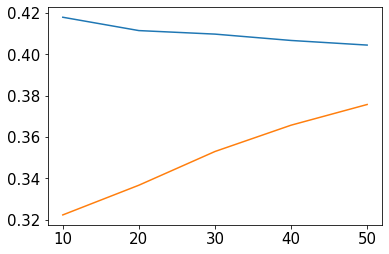

In [445]:
plt.plot(train_sizes,train_scores)
plt.plot(train_sizes,test_scores);

In [447]:
root_c_mat = sklearn.metrics.confusion_matrix(predict_valid,labels_valid[:,0])

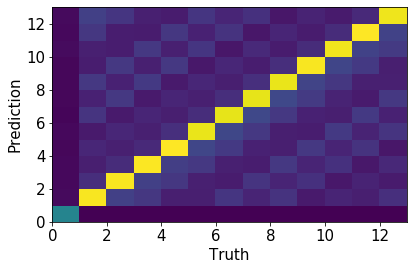

In [448]:
plt.pcolor(root_c_mat)
#plt.xticks(ticks=np.arange(0.5,11.5,1))
#plt.yticks(ticks=np.arange(0.5,11.5,1))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.rc('font', size=15)
plt.tight_layout()

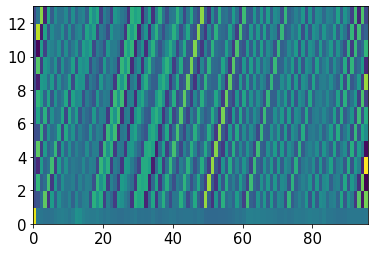

In [449]:
plt.pcolor(root_model.coef_)

### Train quality model on playground set

In [129]:
standard_features_play, standard_labels_play = chord_loader.standardize_root(
    features_play,labels_play,1,transposed=True)

In [130]:
quality_model = sklearn.linear_model.LogisticRegression(class_weight=None,multi_class='ovr',
                                                solver='lbfgs', max_iter=200)

quality_model.fit(standard_features_play, standard_labels_play[:,1]);
standard_predict_play = quality_model.predict(standard_features_play)

print(f"Quality F1 score: {sklearn.metrics.f1_score(standard_predict_play,standard_labels_play[:,1],average='weighted'):.3f}")

quality_c_mat = sklearn.metrics.confusion_matrix(standard_predict_play,standard_labels_play[:,1])

Quality F1 score: 0.846


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


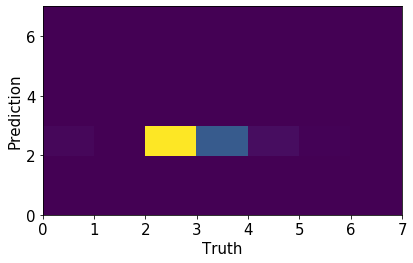

In [497]:
plt.pcolor(quality_c_mat)
#plt.xticks(ticks=np.arange(0.5,11.5,1))
#plt.yticks(ticks=np.arange(0.5,11.5,1))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.rc('font', size=15)
plt.tight_layout()

In [498]:
quality_c_mat

array([[    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [  215,    34, 13583,  3830,   438,    64,    27],
       [    1,     1,    18,    21,     2,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0]])

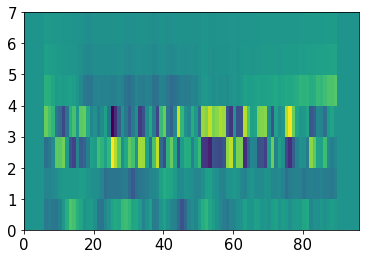

In [499]:
plt.pcolor(quality_model.coef_)

### Producing labels given youtube video

In [50]:
def download_mp3(link,destination):
    options = {
        'format': 'bestaudio/best', # choice of quality
        'extractaudio' : True,      # only keep the audio
        'audioformat' : "mp3",      # convert to mp3 
        'outtmpl': '%(id)s',        # name the file the ID of the video
        'noplaylist' : True,}       # only download single song, not playlist
    ydl = youtube_dl.YoutubeDL(options)

    with ydl:
        # download video
        try:
            result = ydl.extract_info(link, download=True)
            os.rename(result['id'], destination)

        except Exception as e:
            print("Can't download audio! %s\n" % traceback.format_exc())


In [455]:
download_mp3('https://www.youtube.com/watch?v=a__Y4dlP8eo','test.mp3')

[youtube] a__Y4dlP8eo: Downloading webpage
[youtube] a__Y4dlP8eo: Downloading video info webpage
[youtube] Downloading just video a__Y4dlP8eo because of --no-playlist
[download] Destination: a__Y4dlP8eo
[download] 100% of 4.08MiB in 00:0107MiB/s ETA 00:005


In [456]:
song_features = chord_loader.get_features("test.mp3",0.5,21.35,7,1)

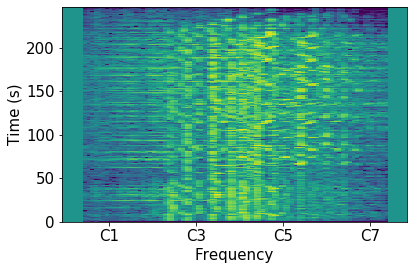

In [491]:
plt.pcolor(range(96),np.arange(0,495/2,0.5),song_features)
plt.xticks(ticks=range(13,90,24),labels=['C1','C3','C5','C7'])
plt.xlabel('Frequency')
plt.ylabel('Time (s)')
plt.rc('font', size=15)
plt.tight_layout()
plt.savefig('Images/feature_ex.png')

In [480]:
!rm test.mp3

In [481]:
root_labels = root_model.predict(song_features)

song_labels = np.zeros((root_labels.shape[0],4))
song_labels[:,1:] = np.nan
song_labels[:,0] = root_labels

standard_song_features, standard_song_labels = chord_loader.standardize_root(
    song_features,song_labels,1)

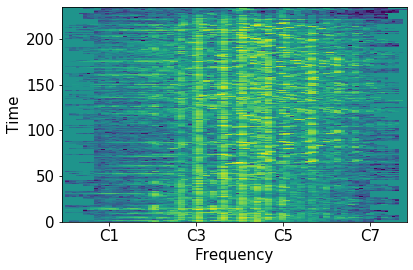

In [492]:
plt.pcolor(range(96),np.arange(0,471/2,0.5),standard_song_features);
plt.xticks(ticks=range(13,90,24),labels=['C1','C3','C5','C7'])
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.rc('font', size=15)
plt.tight_layout()
plt.savefig('Images/standard_feature_ex.png')

In [170]:
quality_labels = quality_model.predict(standard_song_features)

song_labels[~np.equal(song_labels[:,0],-1),1] = quality_labels

chord_symbols = chord_loader.read_chords(song_labels)

In [184]:
chord_symbols[0:5]

['~ ', '~ ', 'E maj', 'E maj', 'F maj']

### Plotting learning curves

In [439]:
def get_metrics(model_prefix,data_prefix,dataset,frac=1):
    """Calculates F1 scores.
    dataset = 'train', 'valid', or 'test'"""
    bins_per_note = 1
    #load models
    root_model = pickle.load(open(f"Models/{model_prefix}_root.pkl", 'rb'))
    quality_model = pickle.load(open(f"Models/{model_prefix}_quality.pkl", 'rb'))
    add_model = pickle.load(open(f"Models/{model_prefix}_add.pkl", 'rb'))
    inv_model = pickle.load(open(f"Models/{model_prefix}_inv.pkl", 'rb'))
    #load data
    features = np.load(f'Data/processed/{data_prefix}_f{dataset}.npy')
    labels = np.load(f'Data/processed/{data_prefix}_l{dataset}.npy')
    standard_features = np.load(f'Data/processed/{data_prefix}_fs{dataset}.npy')
    standard_labels = np.load(f'Data/processed/{data_prefix}_ls{dataset}.npy')
    if dataset == 'train':
        og_size = int(features.shape[0]/12*frac)
        features = features[:og_size,:]
        labels = labels[:og_size,:]
        standard_og_size = int(standard_features.shape[0]*frac)
        standard_features = standard_features[:standard_og_size,:]
        standard_labels = standard_labels[:standard_og_size,:]
    #predict root
    root_labels = root_model.predict(features)
    #root_labels won't be the same shape as other results because rows are removed in standardization
    #result_labels = np.zeros((root_model.shape[0],4))
    #result_labels[:,1:] = np.nan
    #result_labels[:,0] = root_labels
    
    #standardize root
    #standard_features, standard_labels = chord_loader.standardize_root(
    #    features,result_labels,bins_per_note)
    #predict other chord properties
    quality_labels = quality_model.predict(standard_features)
    result_labels = np.zeros((quality_labels.shape[0],4))
    result_labels[:,1] = quality_labels
    result_labels[:,2] = add_model.predict(standard_features)
    result_labels[:,3] = inv_model.predict(standard_features)
    result_labels = np.zeros((quality_labels.shape[0],4))
    
    #now compute metrics
    root_filter = ~np.isnan(labels[:,0])
    quality_filter = ~np.isnan(standard_labels[:,1])
    add_filter = ~np.isnan(standard_labels[:,2])
    inv_filter = ~np.isnan(standard_labels[:,3])
    
    F1_root = sklearn.metrics.f1_score(root_labels[root_filter],labels[root_filter,0],average='weighted')
    F1_quality = sklearn.metrics.f1_score(result_labels[quality_filter,1],
                                          standard_labels[quality_filter,1],average='weighted')
    F1_add = sklearn.metrics.f1_score(result_labels[add_filter,2],
                                          standard_labels[add_filter,2],average='weighted')
    F1_inv = sklearn.metrics.f1_score(result_labels[inv_filter,3],
                                          standard_labels[inv_filter,3],average='weighted')
    return F1_root, F1_quality, F1_add, F1_inv

In [441]:
train_metrics = np.zeros((5,4))
train_metrics[0,:] = get_metrics('default_02','default_lr','train',frac=0.2)
train_metrics[1,:] = get_metrics('default_04','default_lr','train',frac=0.4)
train_metrics[2,:] = get_metrics('default_06','default_lr','train',frac=0.6)
train_metrics[3,:] = get_metrics('default_08','default_lr','train',frac=0.8)
train_metrics[4,:] = get_metrics('default_10','default_lr','train')

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/met

In [442]:
valid_metrics = np.zeros((5,4))
valid_metrics[0,:] = get_metrics('default_02','default_lr','valid')
valid_metrics[1,:] = get_metrics('default_04','default_lr','valid')
valid_metrics[2,:] = get_metrics('default_06','default_lr','valid')
valid_metrics[3,:] = get_metrics('default_08','default_lr','valid')
valid_metrics[4,:] = get_metrics('default_10','default_lr','valid')

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classifi

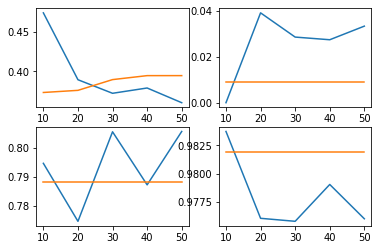

In [443]:
plt.subplot(2,2,1)
plt.plot(range(10,60,10),train_metrics[:,0])
plt.plot(range(10,60,10),valid_metrics[:,0])
plt.subplot(2,2,2)
plt.plot(range(10,60,10),train_metrics[:,1])
plt.plot(range(10,60,10),valid_metrics[:,1])
plt.subplot(2,2,3)
plt.plot(range(10,60,10),train_metrics[:,2])
plt.plot(range(10,60,10),valid_metrics[:,2])
plt.subplot(2,2,4)
plt.plot(range(10,60,10),train_metrics[:,3])
plt.plot(range(10,60,10),valid_metrics[:,3])

Okay, I think this needs some work, and would be a lot easier if it were just incorporated into lr_train

## Building the model

### Setting up bash commands
Now that I've explored a bit, I'm setting up bash commands to process the mp3/chord files, and save the numpy arrays.  The arrays will be saved in `Data/processed/` as npy files.  There will also be a file `Data/processed/directory.csv` with basic info about settings used to process files.

The following command will process the 10% of the data:

```python chord_process.py partial_lr --transpose --standard --frac 0.1```

And the following will process 100% of the data (takes about 2 hours):

```python chord_process.py full_lr --transpose --standard```

After data is processed, I'm training linear regression models, and saving to directory `Models` as pickles.  The following is a test command, using 10% of data

```python lr_train.py partial_lr partial --weighted```

In [ ]:
metrics = pickle.load(open("Models/partial_metrics.pkl", 'rb'))

Lastly, I'd like to set up predictions.  The following command should work:

```python lr_predict.py https://www.youtube.com/watch?v=a__Y4dlP8eo partial 'Sail to the Moon'```

In [42]:
#check results
results = pickle.load(open("Results/Sail to the Moon.pkl", 'rb'))
results[0:10]

,rootnum,qualitynum,addnum,invnum,root,quality,interval,inv,full,notes
0,-1.0,0.0,0.0,0.0,~,,,,~,
1,9.0,4.0,0.0,1.0,A,sus,,/5,Asus/5,E4 A5
2,4.0,1.0,0.0,0.0,E,power,,,Epower,E4 B5 E5
3,9.0,2.0,0.0,0.0,A,maj,,,Amaj,A4 Db5 E5 A5
4,4.0,2.0,0.0,0.0,E,maj,,,Emaj,E4 Ab5 B5 E5
5,9.0,2.0,0.0,1.0,A,maj,,/5,Amaj/5,E4 Db5 E5 A5
6,9.0,2.0,1.0,1.0,A,maj,maj7,/5,Amajmaj7/5,E4 Db5 E5 A5 Ab6
7,9.0,2.0,1.0,1.0,A,maj,maj7,/5,Amajmaj7/5,E4 Db5 E5 A5 Ab6
8,9.0,2.0,1.0,0.0,A,maj,maj7,,Amajmaj7,A4 Db5 E5 A5 Ab6
9,9.0,2.0,1.0,1.0,A,maj,maj7,/5,Amajmaj7/5,E4 Db5 E5 A5 Ab6


### Optimization

To optimize the L2 weight, I generate the following models:

```python lr_train.py full_lr full_1 --C 1.0 --weighted; python lr_train.py full_lr full_03 --C 0.3 --weighted; python lr_train.py full_lr full_01 --C 0.1 --weighted; python lr_train.py full_lr full_3 --C 3.0 --weighted; python lr_train.py full_lr full_10 --C 10.0 --weighted```